<a href="https://colab.research.google.com/github/EugeneLogvinovsky/ITHillel/blob/main/DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [3]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""


def add_noise(img,noise_type="gaussian"):
  
  row,col=28,28
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=var**.5
    noise=np.random.normal(-5.9,5.9,img.shape)
    noise=noise.reshape(row,col)
    img=img+noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img=img+img*noise
    return img

In [4]:
#Here we load the dataset from keras
(xtrain,ytrain),(xtest,ytest)=fashion_mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain),len(xtest)))

4423680/4422102 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [5]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises=["gaussian","speckle"]
noise_ct=0
noise_id=0
traindata=np.zeros((60000,28,28))



for idx in tqdm(range(len(xtrain))):
  
  if noise_ct<(len(xtrain)/2):
    noise_ct+=1
    traindata[idx]=add_noise(xtrain[idx],noise_type=noises[noise_id])
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id])) 




noise_ct=0
noise_id=0
testdata=np.zeros((10000,28,28))

for idx in tqdm(range(len(xtest))):
  
  if noise_ct<(len(xtest)/2):
    noise_ct+=1
    x=add_noise(xtest[idx],noise_type=noises[noise_id])
    testdata[idx]=x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))

 56%|█████▋    | 33880/60000 [00:01<00:01, 21518.70it/s]


gaussian noise addition completed to images


 22%|██▏       | 2180/10000 [00:00<00:00, 21797.32it/s]


speckle noise addition completed to images


 88%|████████▊ | 8788/10000 [00:00<00:00, 22022.30it/s]


gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 21814.18it/s]


speckle noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

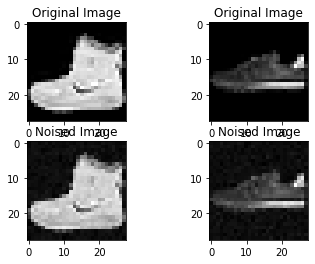

In [6]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0],cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[25000],cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000],cmap="gray")
axes[1,1].set_title("Noised Image")

In [7]:
class noisedDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)

In [8]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,xtrain,ytrain,tsfms)
testset=noisedDataset(testdata,xtest,ytest,tsfms)

In [9]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""


batch_size=32



trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)

In [10]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x

In [11]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

  
model=denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)


epochs=15
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
  
  print("Entering Epoch: ",epoch)
  for dirty,clean,label in tqdm((trainloader)):
    
    
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)
    
    
    
    #-----------------Forward Pass----------------------
    output=model(dirty)
    loss=criterion(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    epochloss+=loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss=0
  print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))

  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
  0%|          | 1/1875 [00:00<04:14,  7.37it/s]

Entering Epoch:  0


  1%|          | 16/1875 [00:00<00:11, 155.43it/s]

======> epoch: 0/15, Loss:0.09644515812397003
Entering Epoch:  1


  1%|          | 16/1875 [00:00<00:12, 153.99it/s]

======> epoch: 1/15, Loss:0.08108581602573395
Entering Epoch:  2


  1%|          | 18/1875 [00:00<00:10, 170.78it/s]

======> epoch: 2/15, Loss:0.06153418496251106
Entering Epoch:  3


  1%|          | 18/1875 [00:00<00:10, 172.76it/s]

======> epoch: 3/15, Loss:0.05911945179104805
Entering Epoch:  4


  1%|          | 17/1875 [00:00<00:11, 167.16it/s]

======> epoch: 4/15, Loss:0.052245136350393295
Entering Epoch:  5


  1%|          | 14/1875 [00:00<00:13, 138.70it/s]

======> epoch: 5/15, Loss:0.05425048992037773
Entering Epoch:  6


  1%|          | 15/1875 [00:00<00:13, 142.60it/s]

======> epoch: 6/15, Loss:0.049568768590688705
Entering Epoch:  7


  1%|          | 15/1875 [00:00<00:12, 144.72it/s]

======> epoch: 7/15, Loss:0.05117160826921463
Entering Epoch:  8


  1%|          | 18/1875 [00:00<00:10, 174.27it/s]

======> epoch: 8/15, Loss:0.04636489227414131
Entering Epoch:  9


  1%|          | 16/1875 [00:00<00:11, 154.95it/s]

======> epoch: 9/15, Loss:0.05626548081636429
Entering Epoch:  10


  1%|          | 14/1875 [00:00<00:13, 139.55it/s]

======> epoch: 10/15, Loss:0.0469789020717144
Entering Epoch:  11


  1%|          | 13/1875 [00:00<00:14, 129.61it/s]

======> epoch: 11/15, Loss:0.04508296400308609
Entering Epoch:  12


  1%|          | 17/1875 [00:00<00:11, 165.24it/s]

======> epoch: 12/15, Loss:0.043564874678850174
Entering Epoch:  13


  1%|          | 16/1875 [00:00<00:12, 152.38it/s]

======> epoch: 13/15, Loss:0.04408979043364525
Entering Epoch:  14


100%|██████████| 1875/1875 [00:11<00:00, 162.30it/s]

======> epoch: 14/15, Loss:0.04395805671811104


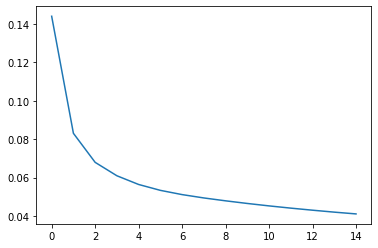

In [12]:
plt.plot(range(len(losslist)),losslist)

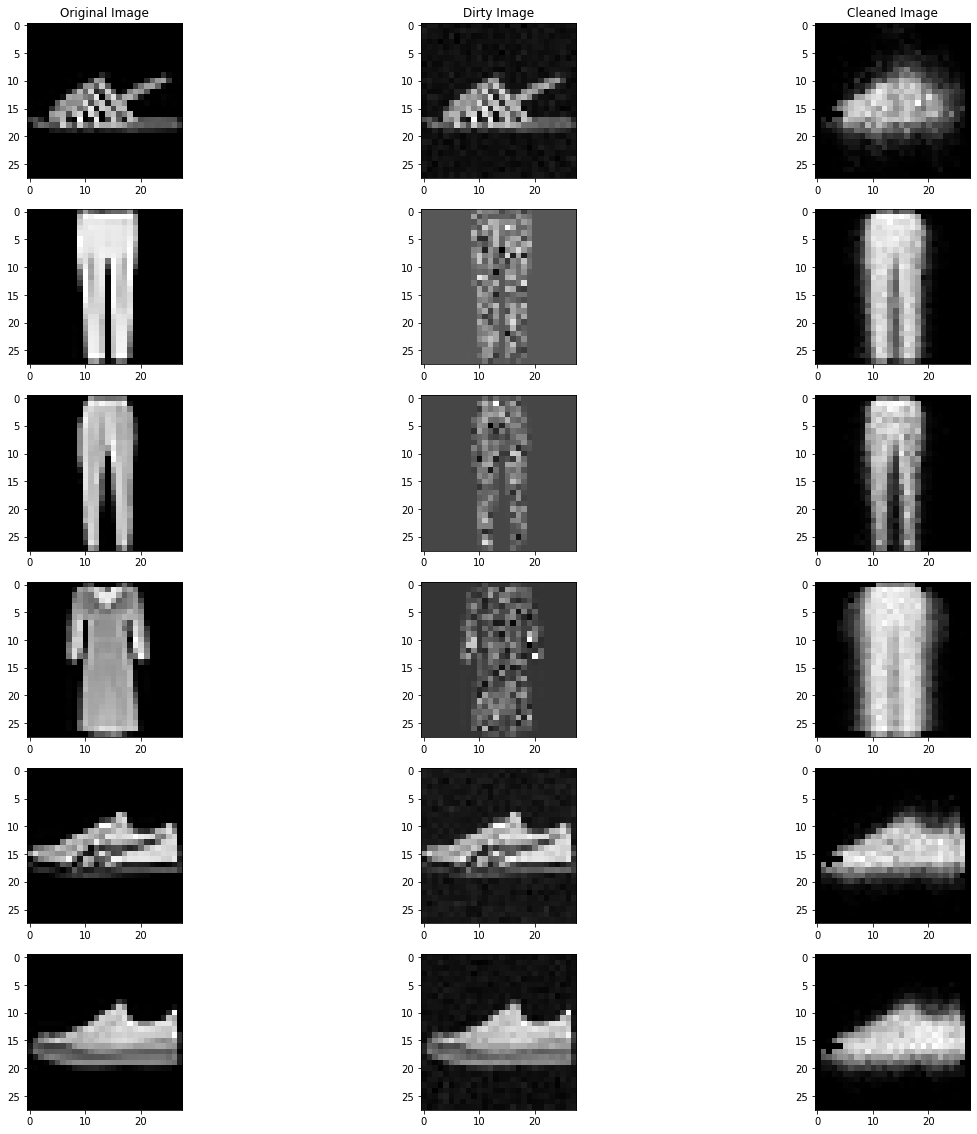

In [13]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
  
 """




f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")